# Análisis de datos Experimento 2
Con 30% de hábitat en el paisaje, 10 niveles de intensificación y 100 comunidades.

In [1]:
import numpy as np
import seaborn, math, os
from matplotlib import pyplot as plt
import scipy.stats as stats

In [2]:
%matplotlib notebook
plt.style.use('seaborn-whitegrid')
#plt.style.use('grayscale')
seaborn.set_palette("deep", color_codes=True)

In [3]:
np.set_printoptions(precision=3, suppress=True)

In [4]:
%run medidas_biodiversidad.py

## Funciones para leer datos, etc

In [5]:
def leer_datos(het):
    files = os.listdir("./datos/exp2")
    files.sort()
    files = list(filter(lambda x: x[6] == het, files))
    
    datos = [np.load("./datos/exp2/" + file) for file in files]
    comunidad = [file[9:12] for file in files]
    
    return datos, comunidad

In [6]:
def calcular_medida(medida, datos, paisajes, bio_min = 5.):
    medidas = np.zeros((100, 10))
    for comunidad in range(len(datos)):
        for intensificacion in range(len(datos[0])):
            medidas[comunidad, intensificacion] = medida(
                                                    datos[comunidad][intensificacion], 
                                                    paisajes[intensificacion],
                                                    t=-2, biomasa_min = bio_min)
    return medidas

In [7]:
def calcular_riqueza(datos, paisajes, bio_min = 5.):
    riquezas = np.zeros((100, 10))
    biomasas = np.zeros((100, 10))

    for comunidad in range(len(datos)):
        for intensificacion in range(len(datos[0])):
            biomasas[comunidad, intensificacion], riquezas[comunidad, intensificacion] = riqueza_agricola(
                                                    datos[comunidad][intensificacion], 
                                                    paisajes[intensificacion],
                                                    t=-2, biomasa_min = bio_min)
    return biomasas, riquezas

In [8]:
def calcular_riquezatotal(datos, bio_min = 5.):
    riquezas = np.zeros((100, 10))
    for comunidad in range(len(datos)):
        for intensificacion in range(len(datos[0])):
            riquezas[comunidad, intensificacion] = riqueza_paisaje(
                                                    datos[comunidad][intensificacion],
                                                    t=-2, biomasa_min = bio_min)[1]
    return riquezas

In [9]:
def calcular_promedio(riquezas):
    """Recibe datos de riqueza.
    """
    promedios = np.zeros(10)
    std = np.zeros(10)
    for i in range(10):
        promedios[i] = np.mean(riquezas[riquezas[:, 0]>=0, i])
        std[i] = np.std(riquezas[:, i])
    return promedios, std

## Leer datos, calcular promedios, sd

In [10]:
paisajes = [None] * 5
for het in range(5):
    paisajes[het] = np.load("paisajes30_h{}.npy".format(het))

In [11]:
datos = [None] * 5
riquezas = [None] * 5
biomasas = [None] * 5
riquezas_mean = [None] * 5
riquezas_sd = [None] * 5
biomasas_mean = [None] * 5
biomasas_sd = [None] * 5

sw = [None] * 5
sw_mean = [None] * 5
sw_sd = [None] * 5


prueba = [None] * 5
prueba_mean = [None] * 5
prueba_sd = [None] * 5

for het in range(5):
    datos[het] = leer_datos(str(het))[0]
    
    biomasas[het], riquezas[het] = calcular_riqueza(datos[het], paisajes[het], bio_min = 15)
    
    #normalizar riquezas: (pensar al respecto)
    #for i in range(len(riquezas[het])):
    #    riquezas[het][i] = riquezas[het][i] / riquezas[het][i, 0] 
    
    riquezas_mean[het], riquezas_sd[het] = calcular_promedio(riquezas[het])
    
    sw[het] = calcular_medida(shannon_wiener, datos[het], paisajes[het], bio_min = 15)
    sw_mean[het], sw_sd[het]  = calcular_promedio(sw[het])
    
    prueba[het] = calcular_medida(medida_prueba,  datos[het], paisajes[het], bio_min = 15)
    prueba_mean[het], prueba_sd[het] = calcular_promedio(prueba[het])
    
    #normalizar biomasas:
    #for i in range(len(biomasas[het])):
    #    biomasas[het][i] = biomasas[het][i] / biomasas[het][i, 0]  
    
    biomasas_mean[het], biomasas_sd[het] = calcular_promedio(biomasas[het])    

In [12]:
riquezatotal = [None] * 5
riquezatotal_mean = [None] * 5
riquezatotal_sd = [None] * 5

for het in range(5):
    riquezatotal[het] = calcular_riquezatotal(datos[het], bio_min = 15)
    riquezatotal_mean[het], riquezatotal_sd[het] = calcular_promedio(riquezatotal[het])  

## Graficar

In [13]:
def graficar(medida, promedios, sd):
    """Graficar promedios de una medida de biodiversidad con curva ajustada ponderada
    """
    %matplotlib inline
    #seaborn.set_palette("deep", color_codes=True)

    y = [None] * 5
    res = [None] * 5
    p = [None] * 5
    r2 = [None] * 5

    x = np.linspace(0, 9, 100)
    xdata = np.array(range(10))
    xlabels = np.array(range(10)) * 10 

    puntos = ["o", "p", "d", "v", "s"]
    colors = ["b", 'g', 'r', 'purple', 'y']

    for het in range(5):
        res[het] = np.polyfit(xdata, promedios[het], 2, w=sd[het])
        p[het] = np.poly1d(res[het])
        r2[het] = 1 - ((np.sum((p[het](range(10)) - promedios[het])**2)) / (np.sum((promedios[het] - np.mean(promedios[het]))**2)))

    fig = plt.figure(figsize=(10, 7), dpi = 50)

    for het in range(0, 5):
        y[het] = p[het](x)
        plt.plot(xdata, promedios[het], 'o', color= colors[het]) #data points
        plt.plot(x, y[het], lw = 3, color= colors[het], label='{} \n $y = {:+.3f} x^2 {:+.3f} x {:+.3f}$ \n $R^2={:.4f}$ '.format(
                                het, float(p[het][2]), float(p[het][1]), float(p[het][0]), float(r2[het]))) #fit
        #plt.errorbar(xdata, promedios[het], yerr=sd[het], fmt=puntos[het], color = colors[het])

    plt.ylim(-0.05)
    plt.xlim(-0.1, 9.1)
    plt.xticks(xdata, xlabels)
    plt.xlabel("% intensificación", size = 15)
    plt.ylabel(medida, size = 15)
    #plt.yscale("log")
    plt.title("Pérdida de {} en paisajes con distinta heterogeneidad".format(medida), size = 15)

    plt.legend(loc='center left', fontsize = "large", title="heterogeneidad", bbox_to_anchor=(1, 0.5))

    plt.show()

In [14]:
def graficar_violin(medida, datos, promedios, sd):
    """Graficar datos con violin plot
    """
    %matplotlib inline
    #seaborn.set_palette("deep", color_codes=True)

    y = [None] * 5
    res = [None] * 5
    p = [None] * 5
    r2 = [None] * 5

    x = np.linspace(0, 9, 100)
    xdata = np.array(range(10))
    xlabels = np.array(range(10)) * 10 

    puntos = ["o", "p", "d", "v", "s"]
    colors = ["b", 'g', 'r', 'purple', 'y']

    for het in [4]:
        res[het] = np.polyfit(xdata, promedios[het], 2, w=sd[het])
        p[het] = np.poly1d(res[het])
        r2[het] = 1 - ((np.sum((p[het](range(10)) - promedios[het])**2)) / (np.sum((promedios[het] - np.mean(promedios[het]))**2)))
    
    fig = plt.figure(figsize=(10, 7), dpi = 100)

    for het in [4]:
            y[het] = p[het](x)
            plt.plot(x, y[het], lw = 3, color= colors[het], label='{} \n $y = {:+.3f} x^2 {:+.3f} x {:+.3f}$ \n $R^2={:.4f}$ '.format(
                                het, float(p[het][2]), float(p[het][1]), float(p[het][0]), float(r2[het]))) #fit
            plt.violinplot(datos[het, :, :], xdata, showmedians=True, showextrema=False, showmeans=True) #data points

    plt.ylim(-0.05)
    plt.xlim(-0.1, 9.1)
    plt.xticks(xdata, xlabels)
    plt.xlabel("% intensificación", size = 15)
    plt.ylabel(medida, size = 15)
    #plt.yscale("log")
    plt.title("Pérdida de {} en paisajes con distinta heterogeneidad".format(medida), size = 15)

    plt.legend(loc='center left', fontsize = "large", title="heterogeneidad", bbox_to_anchor=(1, 0.5))

    plt.show()

## Resultados

¿Cómo se distribuyen los datos? De esto dependen las pruebas de hipótesis que se hacen.

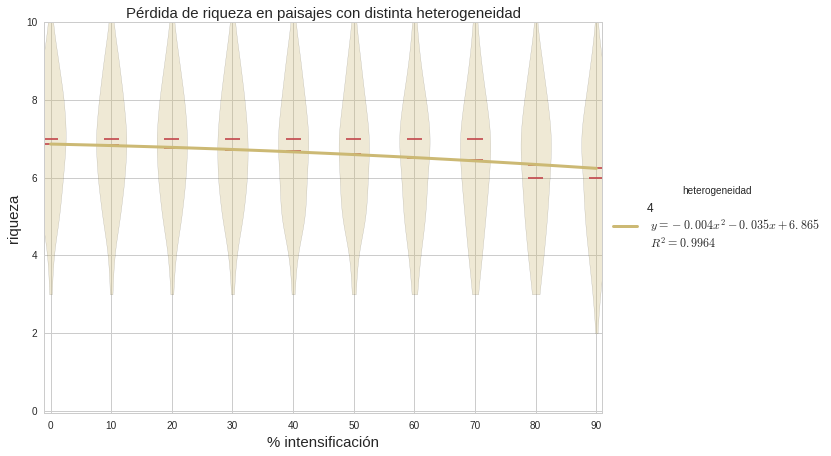

In [15]:
graficar_violin('riqueza', np.array(riquezas), riquezas_mean, riquezas_sd)

### Riqueza

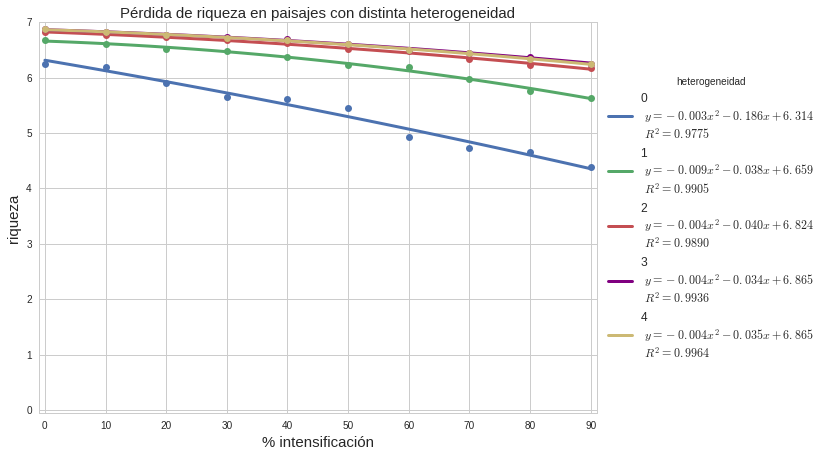

In [16]:
graficar('riqueza', riquezas_mean, riquezas_sd)

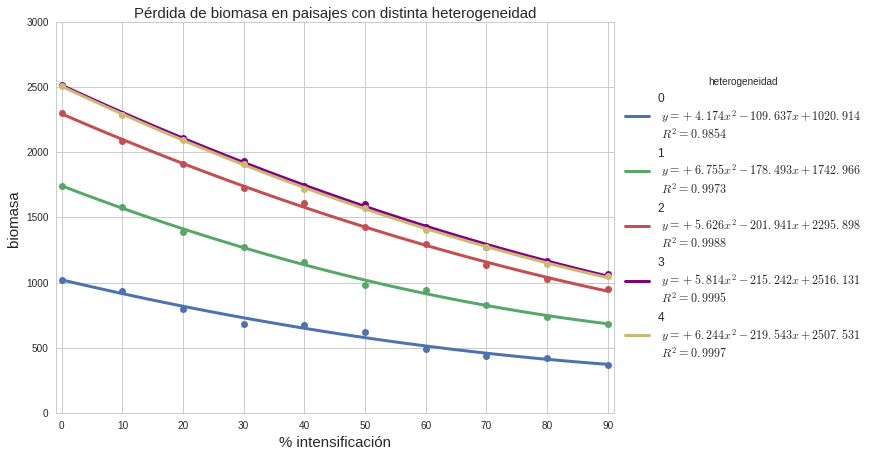

In [17]:
graficar('biomasa', biomasas_mean, biomasas_sd)

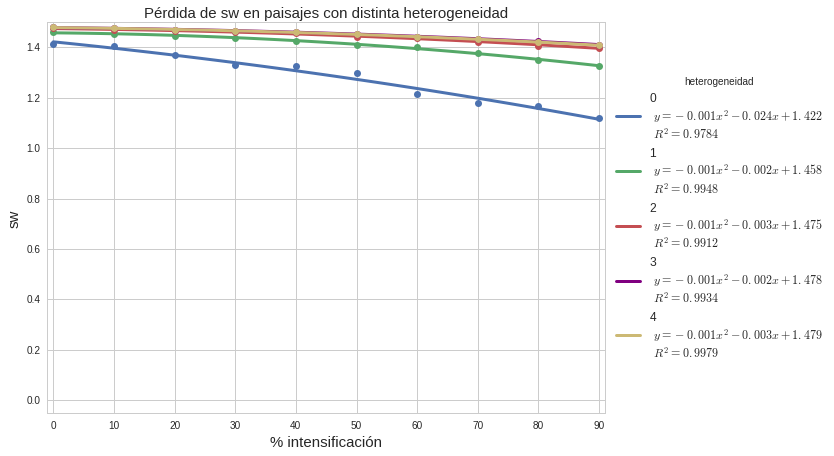

In [18]:
graficar('sw', sw_mean, sw_sd)

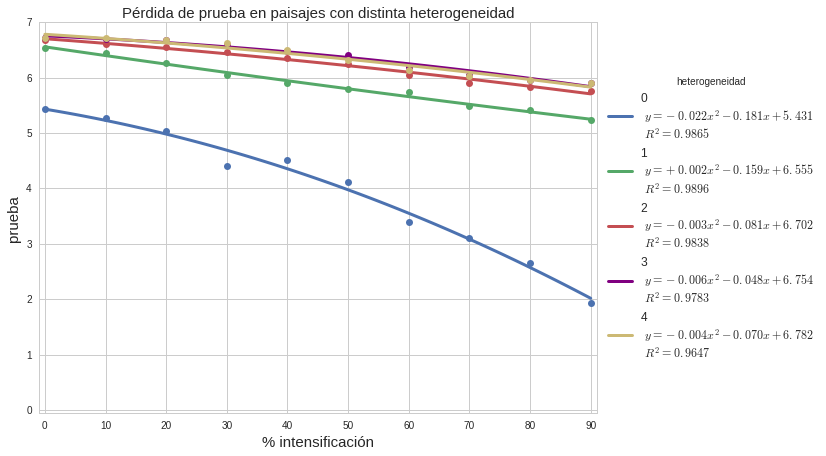

In [19]:
graficar('prueba', prueba_mean, prueba_sd)

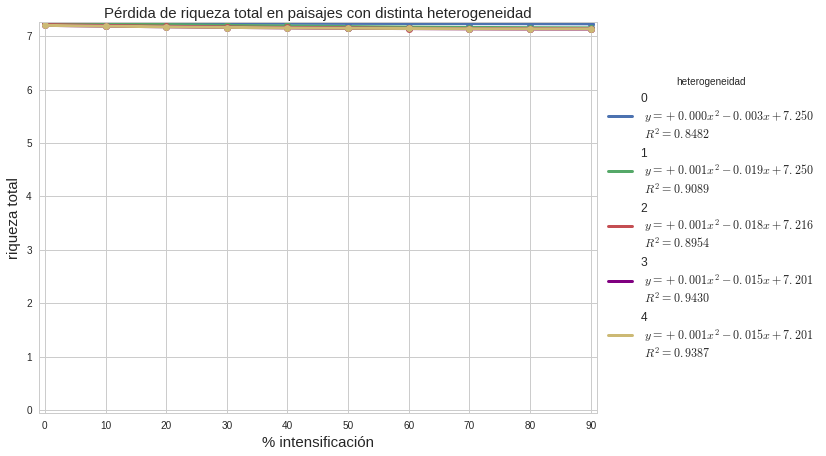

In [20]:
graficar('riqueza total', riquezatotal_mean, riquezatotal_sd)

### Comentarios

## Identificar diferencias significativas

Note: shape of `np.array(biodiversity_measure)` is `[heterogeneity, communities, intensification]`.

In [21]:
# shape: [het, comunidades, intensificación]
# riquezas = np.array(riquezas)
# biomasas = np.array(biomasas)
# pruebas = np.array(prueba)

### Do data distribute normally?

We use Shapiro-Wilk test. Null hypothesis is that data subset came from a normally distributed population.
**Result:** Data subsets don't follow a normal distribution. 

In [23]:
for het in range(5):
    for i in range(10):
        res = 'normal'
        
        data = np.array(riquezas)[het, :, i]
        
        pvalue = stats.shapiro(data)[1]
        if pvalue <= 0.05:
            res = '---NOT NORMAL---'
        print('H{}, i{}, p= {:.4f}, {}'.format(het, i, pvalue, res))

H0, i0, p= 0.0023, ---NOT NORMAL---
H0, i1, p= 0.0013, ---NOT NORMAL---
H0, i2, p= 0.0017, ---NOT NORMAL---
H0, i3, p= 0.0032, ---NOT NORMAL---
H0, i4, p= 0.0024, ---NOT NORMAL---
H0, i5, p= 0.0039, ---NOT NORMAL---
H0, i6, p= 0.0057, ---NOT NORMAL---
H0, i7, p= 0.0048, ---NOT NORMAL---
H0, i8, p= 0.0107, ---NOT NORMAL---
H0, i9, p= 0.0046, ---NOT NORMAL---
H1, i0, p= 0.0042, ---NOT NORMAL---
H1, i1, p= 0.0051, ---NOT NORMAL---
H1, i2, p= 0.0051, ---NOT NORMAL---
H1, i3, p= 0.0057, ---NOT NORMAL---
H1, i4, p= 0.0022, ---NOT NORMAL---
H1, i5, p= 0.0020, ---NOT NORMAL---
H1, i6, p= 0.0012, ---NOT NORMAL---
H1, i7, p= 0.0023, ---NOT NORMAL---
H1, i8, p= 0.0022, ---NOT NORMAL---
H1, i9, p= 0.0033, ---NOT NORMAL---
H2, i0, p= 0.0035, ---NOT NORMAL---
H2, i1, p= 0.0043, ---NOT NORMAL---
H2, i2, p= 0.0041, ---NOT NORMAL---
H2, i3, p= 0.0037, ---NOT NORMAL---
H2, i4, p= 0.0044, ---NOT NORMAL---
H2, i5, p= 0.0048, ---NOT NORMAL---
H2, i6, p= 0.0050, ---NOT NORMAL---
H2, i7, p= 0.0017, ---NOT NO

### Do data have the same variance?

We use Levene test, which does not assume normality. Null hypothesis is that population variances are equal. In particular, we want to know whether data subsets from all heterogeneity levels have the same variance at each intensification level.

**Result:** At each intensification level, subsets from all heterogeneity levels have equal variance.

In [24]:
for i in range(10):
    equal_std = 'equal std'
    pvalue = stats.levene(np.array(riquezas)[0, :, i],
                          np.array(riquezas)[1, :, i],
                          np.array(riquezas)[2, :, i],
                          np.array(riquezas)[3, :, i],
                          np.array(riquezas)[4, :, i], center='median')[1]
    if pvalue <=0.05:
        equal_std = '---std NOT EQUAL---'
    print('i{}, pvalue={:.3f}, {}'.format(i, pvalue, equal_std))

i0, pvalue=0.690, equal std
i1, pvalue=0.613, equal std
i2, pvalue=0.925, equal std
i3, pvalue=0.547, equal std
i4, pvalue=0.633, equal std
i5, pvalue=0.300, equal std
i6, pvalue=0.082, equal std
i7, pvalue=0.056, equal std
i8, pvalue=0.092, equal std
i9, pvalue=0.142, equal std


### Differences between heterogeneity levels

We use Kruskal test to identify significant differences in biodiversity between heterogeneity levels at each level of intensification. Null hypothesis is that population medians are equal.

There is no significant difference between heterogeneity levels 4, 3 and 2. 

In [25]:
# Richness
for i in range(10):
    res = 'no difference'
    pvalue = stats.kruskal(np.array(riquezas)[4, :, i],
                           np.array(riquezas)[3, :, i],
                           np.array(riquezas)[2, :, i])[1]
    if pvalue <=0.05:
        res = '---DIFFERENT---'
    print('i{}, pvalue={:.4f}, {}'.format(i, pvalue, res))

i0, pvalue=0.9670, no difference
i1, pvalue=0.9350, no difference
i2, pvalue=0.9837, no difference
i3, pvalue=0.9652, no difference
i4, pvalue=0.9415, no difference
i5, pvalue=0.9356, no difference
i6, pvalue=0.9953, no difference
i7, pvalue=0.8727, no difference
i8, pvalue=0.8112, no difference
i9, pvalue=0.9669, no difference


In [26]:
# Area
for i in range(10):
    res = 'no difference'
    pvalue = stats.kruskal(np.array(prueba)[4, :, i],
                           np.array(prueba)[3, :, i],
                           np.array(prueba)[2, :, i])[1]
    if pvalue <=0.05:
        res = '---DIFFERENT---'
    print('i{}, pvalue={:.4f}, {}'.format(i, pvalue, res))

i0, pvalue=0.9786, no difference
i1, pvalue=0.8717, no difference
i2, pvalue=0.8766, no difference
i3, pvalue=0.8487, no difference
i4, pvalue=0.8227, no difference
i5, pvalue=0.8277, no difference
i6, pvalue=0.8611, no difference
i7, pvalue=0.8185, no difference
i8, pvalue=0.8666, no difference
i9, pvalue=0.8528, no difference


Heterogeneity levels 4 (highest) and 0 (lowest) are significantly different at all intensification levels.

In [27]:
# Richness
for i in range(10):
    res = 'no difference'
    pvalue = stats.kruskal(np.array(riquezas)[4, :, i],
                           np.array(riquezas)[0, :, i])[1]
    if pvalue <=0.05:
        res = '---DIFFERENT---'
    print('i{}, pvalue={:.4f}, {}'.format(i, pvalue, res))

i0, pvalue=0.0100, ---DIFFERENT---
i1, pvalue=0.0122, ---DIFFERENT---
i2, pvalue=0.0009, ---DIFFERENT---
i3, pvalue=0.0001, ---DIFFERENT---
i4, pvalue=0.0001, ---DIFFERENT---
i5, pvalue=0.0001, ---DIFFERENT---
i6, pvalue=0.0000, ---DIFFERENT---
i7, pvalue=0.0000, ---DIFFERENT---
i8, pvalue=0.0000, ---DIFFERENT---
i9, pvalue=0.0000, ---DIFFERENT---


In [28]:
# Area
for i in range(10):
    res = 'no difference'
    pvalue = stats.kruskal(np.array(prueba)[4, :, i],
                           np.array(prueba)[0, :, i])[1]
    if pvalue <=0.05:
        res = '---DIFFERENT---'
    print('i{}, pvalue={:.4f}, {}'.format(i, pvalue, res))

i0, pvalue=0.0000, ---DIFFERENT---
i1, pvalue=0.0000, ---DIFFERENT---
i2, pvalue=0.0000, ---DIFFERENT---
i3, pvalue=0.0000, ---DIFFERENT---
i4, pvalue=0.0000, ---DIFFERENT---
i5, pvalue=0.0000, ---DIFFERENT---
i6, pvalue=0.0000, ---DIFFERENT---
i7, pvalue=0.0000, ---DIFFERENT---
i8, pvalue=0.0000, ---DIFFERENT---
i9, pvalue=0.0000, ---DIFFERENT---


In [29]:
# Richness
for i in range(10):
    res = 'no difference'
    pvalue = stats.f_oneway(np.array(riquezas)[4, :, i],
                            np.array(riquezas)[0, :, i])[1]
    if pvalue <=0.05:
        res = '---DIFFERENT---'
    print('i{}, pvalue={:.4f}, {}'.format(i, pvalue, res))

i0, pvalue=0.0070, ---DIFFERENT---
i1, pvalue=0.0067, ---DIFFERENT---
i2, pvalue=0.0003, ---DIFFERENT---
i3, pvalue=0.0000, ---DIFFERENT---
i4, pvalue=0.0000, ---DIFFERENT---
i5, pvalue=0.0000, ---DIFFERENT---
i6, pvalue=0.0000, ---DIFFERENT---
i7, pvalue=0.0000, ---DIFFERENT---
i8, pvalue=0.0000, ---DIFFERENT---
i9, pvalue=0.0000, ---DIFFERENT---


At what intensification levels are heterogeneity levels 4, 1 and 0 different from each other? ie At what intensification levels is het1 different from het4 and from het0?

In [30]:
# Richness
for i in range(10):
    res = '-'
    pvalue_14 = stats.kruskal(np.array(riquezas)[4, :, i],
                               np.array(riquezas)[1, :, i])[1]
    
    pvalue_10 = stats.kruskal(np.array(riquezas)[0, :, i],
                               np.array(riquezas)[1, :, i])[1]
    if pvalue_14 <=0.05 and pvalue_10 <= 0.05:
        res = '---DIFFERENT---'
    print('i{}, pvalue_14={:.4f}, pvalue_10={:.4f}, {}'.format(i, pvalue_14, pvalue_10, res))

i0, pvalue_14=0.3669, pvalue_10=0.0899, -
i1, pvalue_14=0.2964, pvalue_10=0.1313, -
i2, pvalue_14=0.3294, pvalue_10=0.0195, -
i3, pvalue_14=0.3391, pvalue_10=0.0031, -
i4, pvalue_14=0.2275, pvalue_10=0.0075, -
i5, pvalue_14=0.1461, pvalue_10=0.0082, -
i6, pvalue_14=0.2381, pvalue_10=0.0000, -
i7, pvalue_14=0.0860, pvalue_10=0.0000, -
i8, pvalue_14=0.0308, pvalue_10=0.0003, ---DIFFERENT---
i9, pvalue_14=0.0326, pvalue_10=0.0000, ---DIFFERENT---


In [32]:
# Area
for i in range(10):
    res = '-'
    pvalue_14 = stats.kruskal(np.array(prueba)[4, :, i],
                               np.array(prueba)[1, :, i])[1]
    
    pvalue_10 = stats.kruskal(np.array(prueba)[0, :, i],
                               np.array(prueba)[1, :, i])[1]
    if pvalue_14 <=0.05 and pvalue_10 <= 0.05:
        res = '---DIFFERENT---'
    print('i{}, pvalue_14={:.4f}, pvalue_10={:.4f}, {}'.format(i, pvalue_14, pvalue_10, res))

i0, pvalue_14=0.4720, pvalue_10=0.0001, -
i1, pvalue_14=0.3080, pvalue_10=0.0000, -
i2, pvalue_14=0.1105, pvalue_10=0.0000, -
i3, pvalue_14=0.0334, pvalue_10=0.0000, ---DIFFERENT---
i4, pvalue_14=0.0276, pvalue_10=0.0000, ---DIFFERENT---
i5, pvalue_14=0.0610, pvalue_10=0.0000, -
i6, pvalue_14=0.1248, pvalue_10=0.0000, -
i7, pvalue_14=0.0466, pvalue_10=0.0000, ---DIFFERENT---
i8, pvalue_14=0.0574, pvalue_10=0.0000, -
i9, pvalue_14=0.0193, pvalue_10=0.0000, ---DIFFERENT---


In [31]:
# Quiero saber si para un mismo nivel de het, los datos de todos los niveles de intensificación tienen la misma std
for het in range(5):
    equal_std = 'equal std'
    pvalue = stats.levene(np.array(riquezas)[het, :, 0],
                      np.array(riquezas)[het, :, 1],
                      np.array(riquezas)[het, :, 2],
                      np.array(riquezas)[het, :, 3],
                      np.array(riquezas)[het, :, 4],
                      np.array(riquezas)[het, :, 5],
                      np.array(riquezas)[het, :, 6],
                      np.array(riquezas)[het, :, 7],
                      np.array(riquezas)[het, :, 8],
                      np.array(riquezas)[het, :, 9], center='median')[1]
    if pvalue <=0.05:
        equal_std = '---std NOT EQUAL---'
    print('h{}, pvalue={:.3f}, {}'.format(het, pvalue, equal_std))

h0, pvalue=0.028, ---std NOT EQUAL---
h1, pvalue=0.987, equal std
h2, pvalue=0.879, equal std
h3, pvalue=0.832, equal std
h4, pvalue=0.870, equal std
